Targeting 3 GitHub repositories for e-commerce analysis:
- spree/spree
- woocommerce/woocommerce
- magento/magento2

Starting data extraction from GitHub API...
Successfully fetched data for spree/spree. Status: 200
Successfully fetched data for woocommerce/woocommerce. Status: 200
Successfully fetched data for magento/magento2. Status: 200

Finished extraction. Total repositories fetched: 3

Sample raw data for the first repository (for inspection):
{
  "id": 3314,
  "node_id": "MDEwOlJlcG9zaXRvcnkzMzE0",
  "name": "spree",
  "full_name": "spree/spree",
  "private": false,
  "owner": {
    "login": "spree",
    "id": 56702,
    "node_id": "MDEyOk9yZ2FuaXphdGlvbjU2NzAy",
    "avatar_url": "https://avatars.githubusercontent.com/u/56702?v=4",
    "gravatar_id": "",
    "url": "https://api.github.com/users/spree",
    "html_url": "https://github.com/spree",
    "followers_url": "https://api.github.com/users/spree/followers",
    "following_url": "https://api.github.com/users/spree/followi

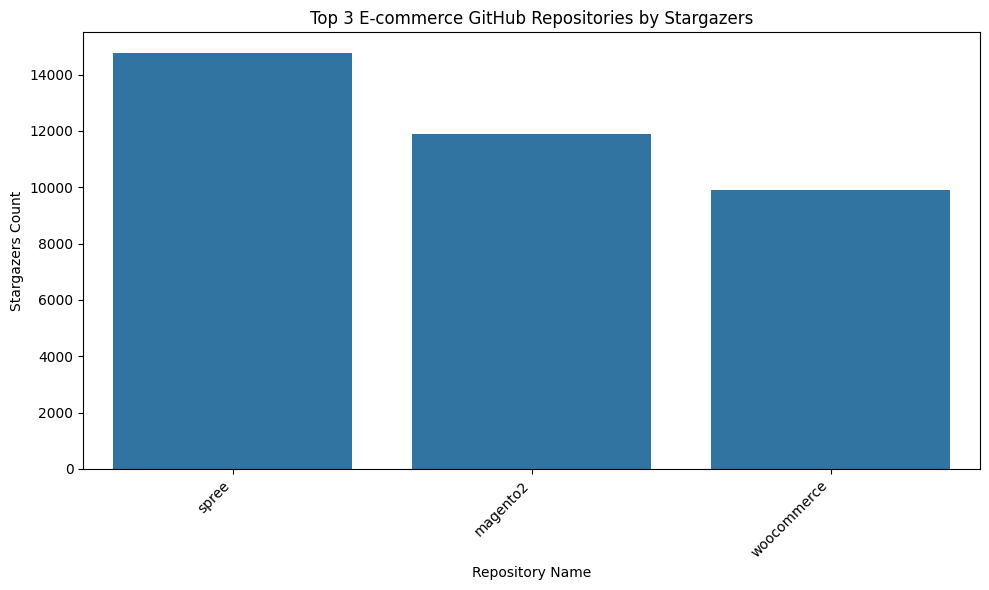

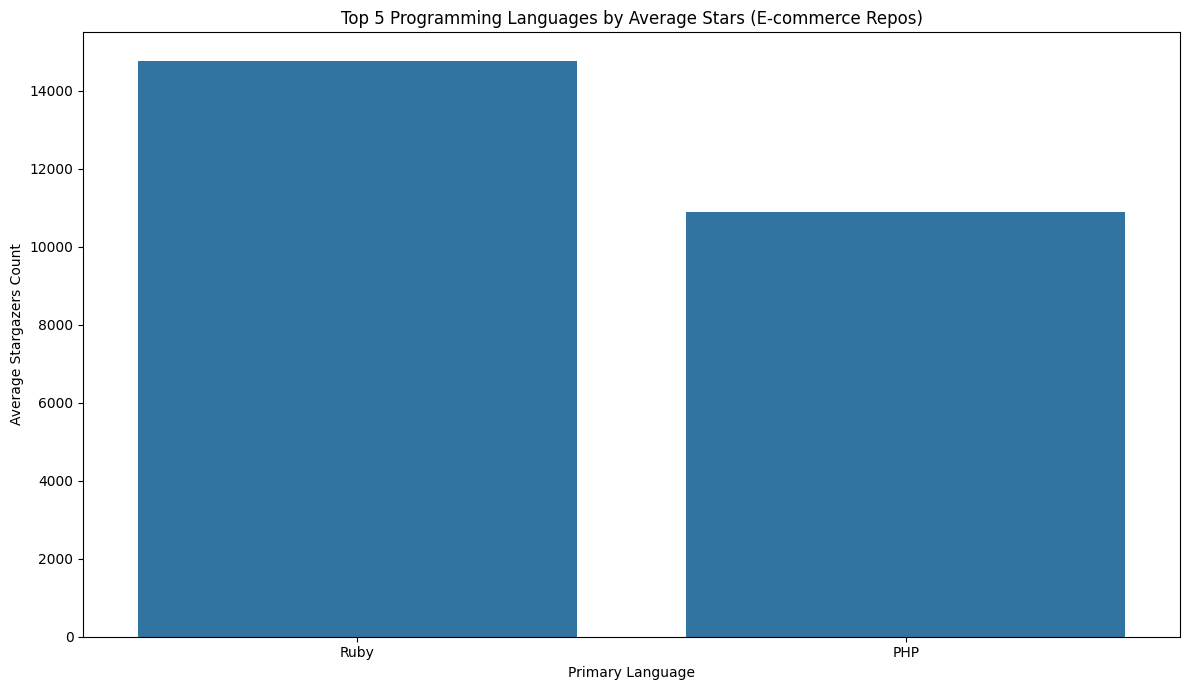

In [1]:
!pip install requests pandas google-cloud-bigquery matplotlib seaborn
import pandas as pd
# Define e-commerce related repositories
# Format: 'owner/repo_name'
target_repos = [
    'spree/spree',
    'woocommerce/woocommerce',
    'magento/magento2',
]

print(f"Targeting {len(target_repos)} GitHub repositories for e-commerce analysis:")
for repo in target_repos:
    print(f"- {repo}")

import requests
from google.colab import userdata # To securely get your PAT
import json # Ensure json is imported for pretty printing

# Retrieve your GitHub PAT from Colab secrets
# Using your specified secret name 'GitHubToken'
github_token = userdata.get('GitHubToken') # Changed variable name to lowercase for consistency
headers = {
    "Accept": "application/vnd.github+json",
    "Authorization": f"Bearer {github_token}",
    "X-GitHub-Api-Version": "2022-11-28"
}

raw_repo_data = []

print("\nStarting data extraction from GitHub API...")
for repo_path in target_repos:
    owner, repo_name = repo_path.split('/')
    url = f"https://api.github.com/repos/{owner}/{repo_name}"
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status() # Raises HTTPError for bad responses (4xx or 5xx)
        repo_json = response.json()
        raw_repo_data.append(repo_json)
        print(f"Successfully fetched data for {repo_path}. Status: {response.status_code}")
        # Optional: print rate limit info for debugging
        # print(f"  Rate Limit Remaining: {response.headers.get('X-RateLimit-Remaining')}")
    except requests.exceptions.HTTPError as errh:
        print(f"HTTP Error for {repo_path}: {errh}")
    except requests.exceptions.ConnectionError as errc:
        print(f"Error Connecting for {repo_path}: {errc}")
    except requests.exceptions.Timeout as errt:
        print(f"Timeout Error for {repo_path}: {errt}")
    except requests.exceptions.RequestException as err:
        print(f"An unexpected error occurred for {repo_path}: {err}")
    except Exception as e:
        print(f"General error processing {repo_path}: {e}")

print(f"\nFinished extraction. Total repositories fetched: {len(raw_repo_data)}")

# JSON structure of the first fetched repository (inspection)
if raw_repo_data:
    print("\nSample raw data for the first repository (for inspection):")
    print(json.dumps(raw_repo_data[0], indent=2))
else:
    print("raw_repo_data is empty. Please ensure Phase 2, Step 5 ran successfully and fetched data.")

# Data cleaning/enrichment

print("\nProceeding to transform raw JSON into a structured DataFrame...")

transformed_data = []
for repo_json in raw_repo_data:
    license_info = repo_json.get('license')

    # Save license_info for dictionary, just in case.
    license_name_value = license_info.get('name') if isinstance(license_info, dict) else None

    extracted = {
        'repo_name': repo_json.get('name'),
        'owner_login': repo_json.get('owner', {}).get('login'),
        'description': repo_json.get('description'),
        'stargazers_count': repo_json.get('stargazers_count'),
        'forks_count': repo_json.get('forks_count'),
        'language': repo_json.get('language'),
        'created_at': repo_json.get('created_at'),
        'updated_at': repo_json.get('updated_at'),
        'pushed_at': repo_json.get('pushed_at'),
        'size_kb': repo_json.get('size'), # GitHub API 'size' is in KB
        'open_issues_count': repo_json.get('open_issues_count'),
        'license_name': license_name_value
    }
    transformed_data.append(extracted)

df_repos = pd.DataFrame(transformed_data)

# Data Cleaning Pt. 2

# Convert date columns to datetime objects
df_repos['created_at'] = pd.to_datetime(df_repos['created_at'], errors='coerce', utc=True)
df_repos['updated_at'] = pd.to_datetime(df_repos['updated_at'], errors='coerce', utc=True)
df_repos['pushed_at'] = pd.to_datetime(df_repos['pushed_at'], errors='coerce', utc=True)

#Fill NaNs with 0 and convert to integer type
numeric_cols = ['stargazers_count', 'forks_count', 'size_kb', 'open_issues_count']
for col in numeric_cols:
    # Fill any NaN/None with 0 (a reasonable default for counts/size)
    # make sure column is integer type
    df_repos[col] = df_repos[col].fillna(0).astype(int)

# 3. Handle string columns: Fill None/NaN with empty strings or descriptive placeholders
df_repos['description'] = df_repos['description'].fillna('') # Empty string for missing description
df_repos['language'] = df_repos['language'].fillna('Undetermined') # 'Undetermined' for missing language
df_repos['license_name'] = df_repos['license_name'].fillna('No License') # 'No License' for missing license

# Data Enrichment Pt. 2

current_utc_time = pd.Timestamp('2025-07-24 11:28:24', tz='UTC') # Using the exact current time provided for consistency

# Calculate Repository Age (in days)
df_repos['repo_age_days'] = (current_utc_time - df_repos['created_at']).dt.days.fillna(-1).astype(int)

# Calculate Days Since Last Push (in days)
df_repos['days_since_last_push'] = (current_utc_time - df_repos['pushed_at']).dt.days.fillna(-1).astype(int)


# Test Results of Transformation
print("\nTransformed DataFrame Head (after cleaning and enrichment):")
print(df_repos.head())

print("\nTransformed DataFrame Info (check for non-null counts and dtypes):")
print(df_repos.info())

print("\nNull counts after cleaning and enrichment:")
print(df_repos.isnull().sum()) # This should show 0 for many columns now

# Data Loading
from google.colab import auth
from google.cloud import bigquery

# Authenticate Colab session to GCP
print("\nAuthenticating Colab to Google Cloud...")
auth.authenticate_user()
print("Authentication complete.")

# Google Cloud Project ID and BigQuery data
project_id = 'bigdata-etl-github' # The Google Cloud Project ID
dataset_id = 'ecommerce_repos_data' # BigQuery Dataset
table_id = 'github_repo_metrics'    # Table name

# Full table path for BigQuery
full_table_id = f"{project_id}.{dataset_id}.{table_id}"

# BigQuery Client
print(f"Initializing BigQuery client for project: {project_id}")
client = bigquery.Client(project=project_id)

# Load Job Configuration
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE", # This will replace the table if it already exists
                                        # Use "WRITE_APPEND" if you want to add new rows
)

# 5. Load DataFrame to BigQuery
print(f"Attempting to load {len(df_repos)} rows into BigQuery table: {full_table_id}")
try:
    job = client.load_table_from_dataframe(
        df_repos, full_table_id, job_config=job_config
    )
    job.result()

    print(f"Successfully loaded {job.output_rows} rows into {full_table_id}")
    print(f"You can view your data in BigQuery console: https://console.cloud.google.com/bigquery?project={project_id}&d={dataset_id}&p={project_id}&t={table_id}&page=table")
except Exception as e:
    print(f"Error loading data to BigQuery: {e}")
    print("Please check your project ID, dataset ID, and ensure BigQuery API is enabled.")

# Data Analysis and Visualization

print("\nPerforming example analysis using BigQuery SQL from Colab...")

# Example: Top 3 E-commerce Repos by Stars
query_top_stars = f"""
SELECT
    repo_name,
    owner_login,
    language,
    stargazers_count,
    forks_count,
    open_issues_count,
    days_since_last_push
FROM
    `{project_id}.{dataset_id}.{table_id}`
ORDER BY
    stargazers_count DESC
LIMIT 3
"""
try:
    top_stars_df = client.query(query_top_stars).to_dataframe()
    print("\nTop 3 E-commerce Related Repos by Stars:")
    print(top_stars_df)
except Exception as e:
    print(f"Error running Top Stars query: {e}")

# Example: Average stars and forks by primary language
query_avg_by_language = f"""
SELECT
    language,
    COUNT(repo_name) AS num_repos,
    AVG(stargazers_count) AS avg_stars,
    AVG(forks_count) AS avg_forks
FROM
    `{project_id}.{dataset_id}.{table_id}`
WHERE language IS NOT NULL AND language != 'Undetermined' -- Exclude 'Undetermined' for average language analysis
GROUP BY
    language
ORDER BY
    avg_stars DESC
"""
try:
    avg_by_language_df = client.query(query_avg_by_language).to_dataframe()
    print("\nAverage Stars & Forks by Language (for E-commerce Repos):")
    print(avg_by_language_df)
except Exception as e:
    print(f"Error running Average by Language query: {e}")

# Matplotlib/Seaborn to visualize these Pandas DataFrames
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations
if not top_stars_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='repo_name', y='stargazers_count', data=top_stars_df)
    plt.title('Top 3 E-commerce GitHub Repositories by Stargazers')
    plt.xlabel('Repository Name')
    plt.ylabel('Stargazers Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo data for Top 3 E-commerce Repos by Stargazers visualization.")

if not avg_by_language_df.empty:
    plt.figure(figsize=(12, 7))
    sns.barplot(x='language', y='avg_stars', data=avg_by_language_df.head(5))
    plt.title('Top 5 Programming Languages by Average Stars (E-commerce Repos)')
    plt.xlabel('Primary Language')
    plt.ylabel('Average Stargazers Count')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo data for Average Stars & Forks by Language visualization.")
